# Program for Assessing the Creditworthiness of Borrowers Based on the Logistic Regression Algorithm (python notebook)

## Deadlines:
* 20.02.2023  Exploratory data analysis of the selected scoring dataset  
* 24.02.2023  Binary logit regression model baseline  
* 03.03.2023  Feature engineering/selection/elimination  
* 06.03.2023  Final logistic regression model

# Dataset:

## Link:
https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk

## Context
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.

## Attribute Information:

1. Age (numeric)  
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

## Additional useful info on the original dataset:
  
Attribute 1: (qualitative)  
Status of existing checking account  
A11 : ... < 0 DM  
A12 : 0 <= ... < 200 DM  
A13 : ... >= 200 DM / salary assignments for at least 1 year  
A14 : no checking account  
  
Attibute 6: (qualitative)  
Savings account/bonds  
A61 : ... < 100 DM  
A62 : 100 <= ... < 500 DM  
A63 : 500 <= ... < 1000 DM  
A64 : .. >= 1000 DM  
A65 : unknown/ no savings account  

# Code

## Imports

Dependencies:
python3.10.9

In [97]:
# %pip install pandas
# %pip install scikit-learn
# %pip install xgboost
# %pip install xlrd

# %pip install seaborn
# %pip install matplotlib

In [157]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import pickle

np.random.seed(42)

In [99]:
data = pd.read_csv('data/german_credit_data.csv', index_col=0)
data.columns = [col.lower().strip().replace(' ', '_') for col in data.columns]
data.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Currency  
dataset was contributed on 1994-11-17 and has "credit amount" field in deutsche marks, so let's covert currency to usd on that date
- USD/DEM (United States dollar/Deutsche Mark) Nov 1994 (11.1994) exchange rate: 1.54 (https://freecurrencyrates.com/en/exchange-rate-history/USD-DEM/1994/cbr)
- Cumulative rate of inflation on current date (May, 2023): 102.65% (https://www.usinflationcalculator.com/inflation/calculator-cumulative/)

In [100]:
data['credit_amount'] = data['credit_amount'] * 1.54 * 2.0265
data.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,3648.22689,6,radio/TV,good
1,22,female,2,own,little,moderate,18571.94031,48,radio/TV,bad
2,49,male,1,own,little,NaN,6541.21776,12,education,good
3,45,male,2,free,little,little,24598.22442,42,furniture/equipment,good
4,53,male,2,free,little,little,15198.34470,24,car,bad


## Exploratory Data Analysis

In [101]:
data.describe()

,age,job,credit_amount,duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,10208.974679,20.903000
std,11.375469,0.653614,8809.225470,12.058814
min,19.000000,0.000000,780.202500,4.000000
25%,27.000000,2.000000,4261.466055,12.000000
50%,33.000000,2.000000,7238.718795,18.000000
75%,42.000000,2.000000,12396.637522,24.000000
max,75.000000,3.000000,57497.803440,72.000000


In [102]:
data.shape

(1000, 10)

In [103]:
data.dtypes

age                   int64
sex                  object
job                   int64
housing              object
saving_accounts      object
checking_account     object
credit_amount       float64
duration              int64
purpose              object
risk                 object
dtype: object

Target class balance: 700/300


([<matplotlib.patches.Wedge at 0x28f1fdb10>,
 [Text(-0.6465637441936393, 0.8899187180267096, 'Good'),
  Text(0.7053422663930609, -0.9708204196655015, 'Bad')])

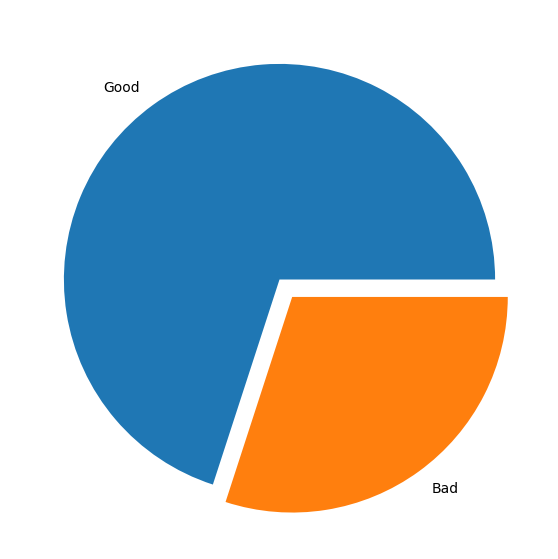

In [104]:
fig, ax = plt.subplots(figsize=(7, 7))
labels = ['Good', 'Bad']
text = f'Total:\n{data.shape[0]}'
print('Target class balance: {}'.format(str(data['risk'].value_counts()[0]) + '/' + str(data['risk'].value_counts()[1])))

plt.pie(data['risk'].value_counts(), labels=labels, explode=[0, 0.1])

Sex class balance: 690/310


([<matplotlib.patches.Wedge at 0x2899b1870>,
 [Text(-0.6182917088228987, 0.90978863633311, 'Male'),
  Text(0.6745000459886166, -0.9924966941815747, 'Female')])

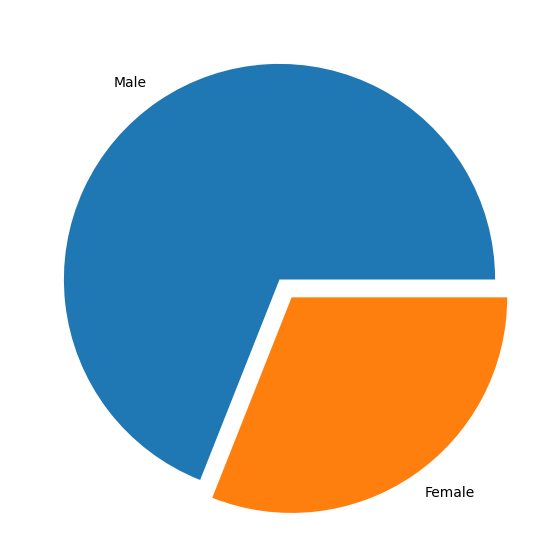

In [105]:
fig, ax = plt.subplots(figsize=(7, 7))
labels = ['Male', 'Female']
text = f'Total:\n{data.shape[0]}'
print('Sex class balance: {}'.format(str(data['sex'].value_counts()[0]) + '/' + str(data['sex'].value_counts()[1])))

plt.pie(data['sex'].value_counts(), labels=labels, explode=[0, 0.1])

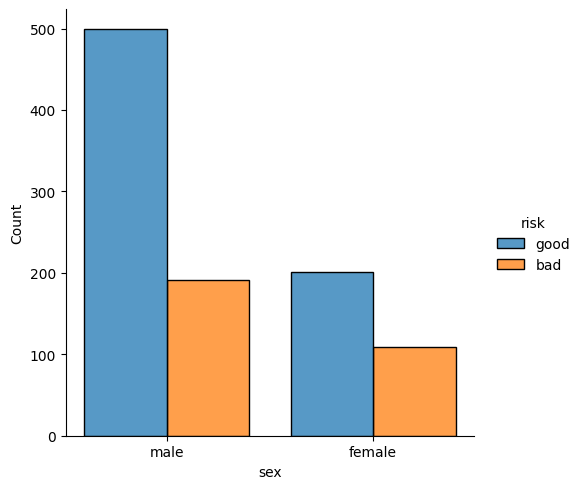

In [106]:
sns.displot(data, x='sex', hue='risk', multiple='dodge', shrink=0.8)

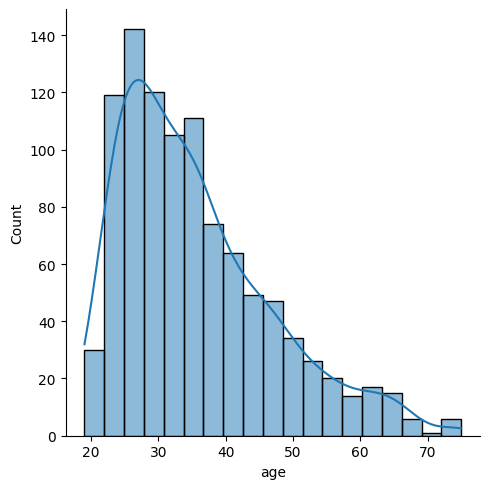

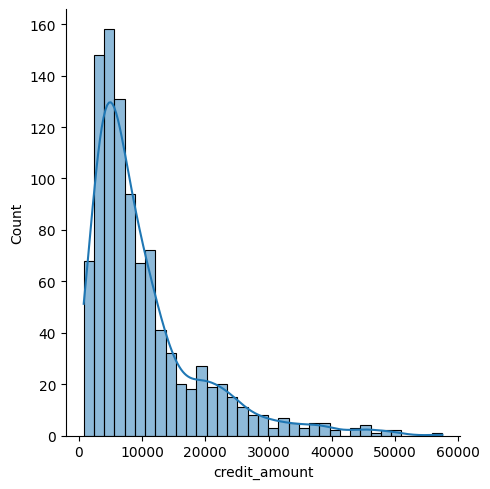

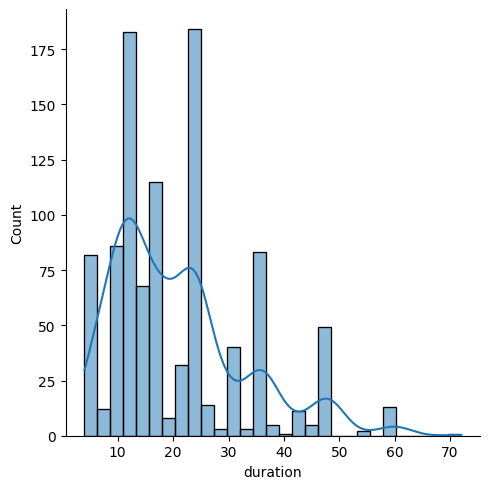

In [107]:
sns.displot(data['age'], kde=True)
sns.displot(data['credit_amount'], kde=True)
sns.displot(data['duration'], kde=True)

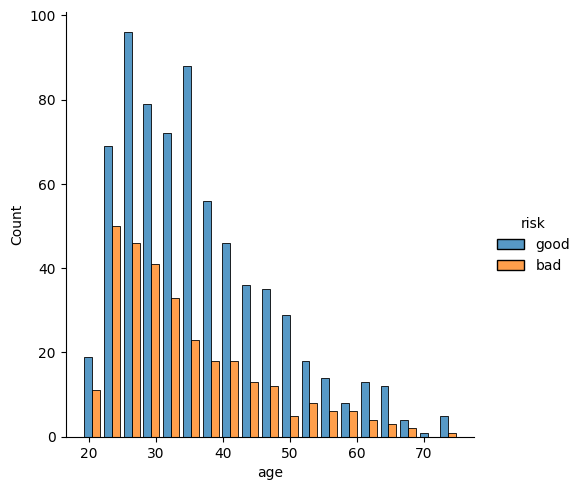

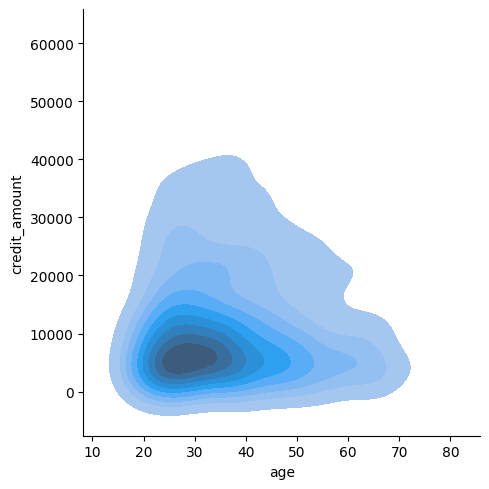

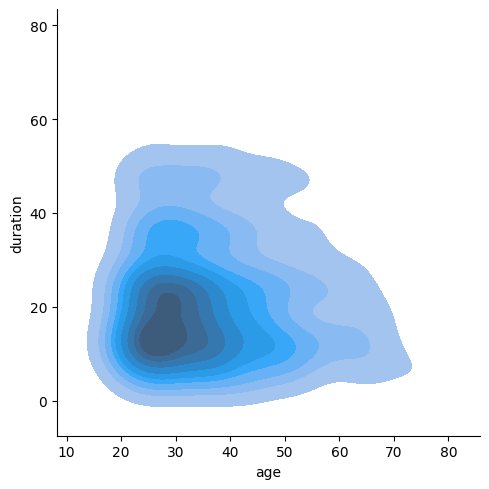

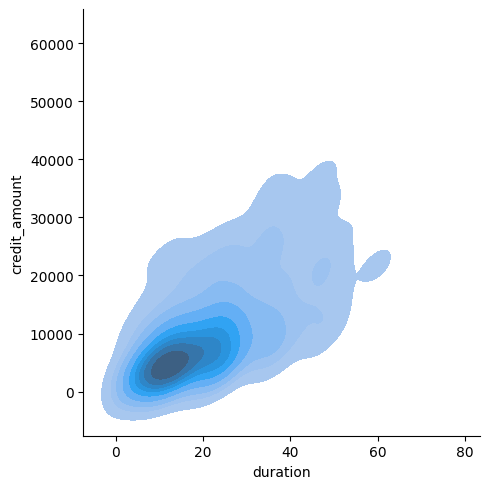

In [108]:
sns.displot(data, x='age', hue='risk', multiple='dodge', shrink=0.8)

sns.displot(data, x='age', y='credit_amount', kind='kde', fill=True)
sns.displot(data, x='age', y='duration', kind='kde', fill=True)
sns.displot(data, x='duration', y='credit_amount', kind='kde', fill=True)

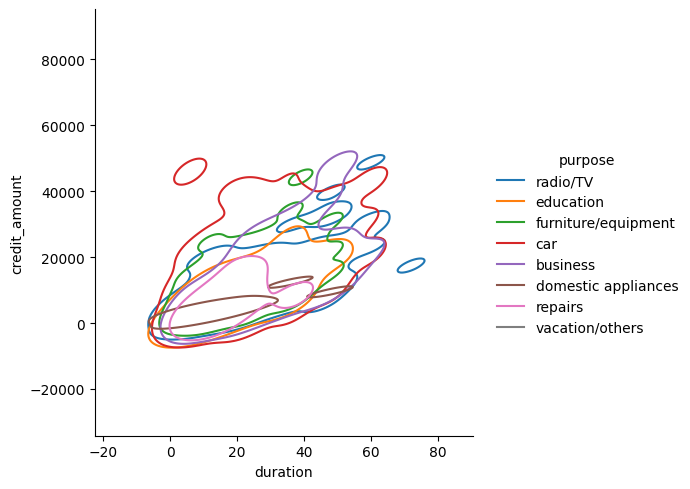

In [109]:
sns.displot(data, x='duration', y='credit_amount', hue='purpose', kind='kde', levels=1)

<Axes: xlabel='purpose', ylabel='credit_amount'>

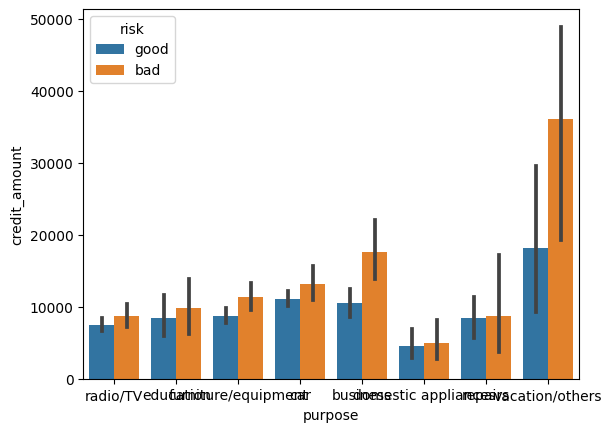

In [110]:
sns.barplot(data, x='purpose', y='credit_amount', hue='risk')

In [111]:
data['sex'] = pd.get_dummies(data['sex']).drop(columns='male').rename(columns={'female': 'sex'}).astype('int64')
data['risk'] = pd.get_dummies(data['risk']).drop(columns='good').rename(columns={'bad': 'risk'}).astype('int64')
data

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,0,2,own,NaN,little,3648.22689,6,radio/TV,0
1,22,1,2,own,little,moderate,18571.94031,48,radio/TV,1
2,49,0,1,own,little,NaN,6541.21776,12,education,0
3,45,0,2,free,little,little,24598.22442,42,furniture/equipment,0
4,53,0,2,free,little,little,15198.34470,24,car,1
...,...,...,...,...,...,...,...,...,...,...
995,31,1,1,own,little,NaN,5417.72616,12,furniture/equipment,0
996,40,0,3,own,little,little,12036.96417,30,car,0
997,38,0,2,own,little,NaN,2509.13124,12,radio/TV,0
998,23,0,2,free,little,little,5757.89445,45,radio/TV,1


## Filling NAs

In [112]:
data.isna().sum()

age                   0
sex                   0
job                   0
housing               0
saving_accounts     183
checking_account    394
credit_amount         0
duration              0
purpose               0
risk                  0
dtype: int64

In [113]:
data['checking_account'].value_counts()

little      274
moderate    269
rich         63
Name: checking_account, dtype: int64

In [114]:
data['saving_accounts'].value_counts()

little        603
moderate      103
quite rich     63
rich           48
Name: saving_accounts, dtype: int64

In [115]:
# Don't actually need right now 
# data = data.fillna('unknown')
# data

## Job from ordinal to dummy encoding

In [116]:
data = pd.concat([data,
           pd.get_dummies(data['job'],  dtype='int64').rename(columns={0: 'job_unskilled_non_resident', 
                                    1: 'job_unskilled_and_resident',
                                    2: 'job_skilled',
                                    3: 'job_highly_skilled'})
], axis=1).drop(columns=['job'])

data

,age,sex,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk,job_unskilled_non_resident,job_unskilled_and_resident,job_skilled,job_highly_skilled
0,67,0,own,NaN,little,3648.22689,6,radio/TV,0,0,0,1,0
1,22,1,own,little,moderate,18571.94031,48,radio/TV,1,0,0,1,0
2,49,0,own,little,NaN,6541.21776,12,education,0,0,1,0,0
3,45,0,free,little,little,24598.22442,42,furniture/equipment,0,0,0,1,0
4,53,0,free,little,little,15198.34470,24,car,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,own,little,NaN,5417.72616,12,furniture/equipment,0,0,1,0,0
996,40,0,own,little,little,12036.96417,30,car,0,0,0,0,1
997,38,0,own,little,NaN,2509.13124,12,radio/TV,0,0,0,1,0
998,23,0,free,little,little,5757.89445,45,radio/TV,1,0,0,1,0


## Categorical encoding

In [117]:
pd.get_dummies(data).shape

(1000, 27)

In [118]:
data = pd.get_dummies(data)
data

,age,sex,credit_amount,duration,risk,job_unskilled_non_resident,job_unskilled_and_resident,job_skilled,job_highly_skilled,housing_free,...,checking_account_moderate,checking_account_rich,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,67,0,3648.22689,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,22,1,18571.94031,48,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,49,0,6541.21776,12,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,45,0,24598.22442,42,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,53,0,15198.34470,24,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,5417.72616,12,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
996,40,0,12036.96417,30,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
997,38,0,2509.13124,12,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
998,23,0,5757.89445,45,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0


In [119]:
data.isna().sum()

age                            0
sex                            0
credit_amount                  0
duration                       0
risk                           0
job_unskilled_non_resident     0
job_unskilled_and_resident     0
job_skilled                    0
job_highly_skilled             0
housing_free                   0
housing_own                    0
housing_rent                   0
saving_accounts_little         0
saving_accounts_moderate       0
saving_accounts_quite rich     0
saving_accounts_rich           0
checking_account_little        0
checking_account_moderate      0
checking_account_rich          0
purpose_business               0
purpose_car                    0
purpose_domestic appliances    0
purpose_education              0
purpose_furniture/equipment    0
purpose_radio/TV               0
purpose_repairs                0
purpose_vacation/others        0
dtype: int64

In [120]:
data = data.replace({True: 1, False: 0})
data

,age,sex,credit_amount,duration,risk,job_unskilled_non_resident,job_unskilled_and_resident,job_skilled,job_highly_skilled,housing_free,...,checking_account_moderate,checking_account_rich,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,67,0,3648.22689,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,22,1,18571.94031,48,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,49,0,6541.21776,12,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,45,0,24598.22442,42,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,53,0,15198.34470,24,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,5417.72616,12,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
996,40,0,12036.96417,30,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
997,38,0,2509.13124,12,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
998,23,0,5757.89445,45,1,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0


In [121]:
data.dtypes

age                              int64
sex                              int64
credit_amount                  float64
duration                         int64
risk                             int64
job_unskilled_non_resident       int64
job_unskilled_and_resident       int64
job_skilled                      int64
job_highly_skilled               int64
housing_free                     uint8
housing_own                      uint8
housing_rent                     uint8
saving_accounts_little           uint8
saving_accounts_moderate         uint8
saving_accounts_quite rich       uint8
saving_accounts_rich             uint8
checking_account_little          uint8
checking_account_moderate        uint8
checking_account_rich            uint8
purpose_business                 uint8
purpose_car                      uint8
purpose_domestic appliances      uint8
purpose_education                uint8
purpose_furniture/equipment      uint8
purpose_radio/TV                 uint8
purpose_repairs          

<Axes: >

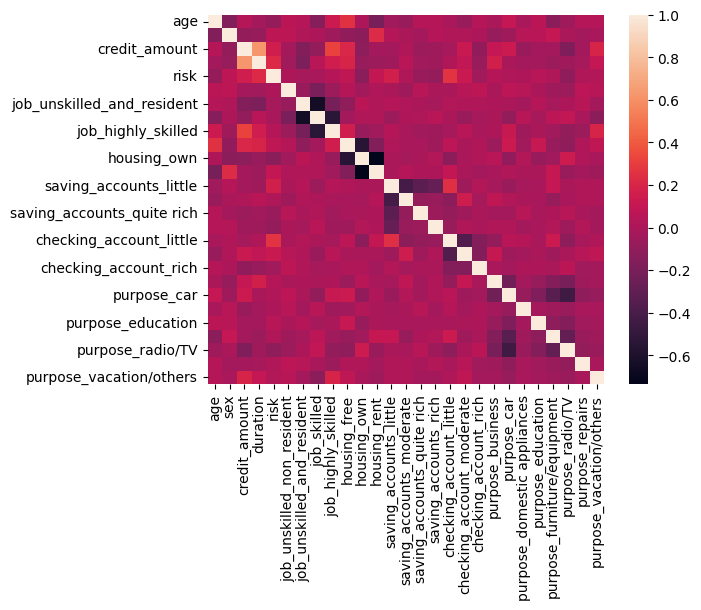

In [122]:
sns.heatmap(data.corr())

In [123]:
data.columns = [col.lower().strip().replace(' ', '_').replace('/', '_') for col in data.columns]
data.corr()['risk'].sort_values()

housing_own                   -0.134589
purpose_radio_tv              -0.106922
age                           -0.091127
saving_accounts_rich          -0.085749
saving_accounts_quite_rich    -0.070954
checking_account_rich         -0.044009
job_unskilled_and_resident    -0.021822
job_skilled                   -0.013559
job_unskilled_non_resident     0.005951
purpose_domestic_appliances    0.008016
purpose_repairs                0.020828
purpose_furniture_equipment    0.020971
saving_accounts_moderate       0.022255
purpose_car                    0.022621
purpose_vacation_others        0.028058
purpose_business               0.036129
job_highly_skilled             0.040559
purpose_education              0.049085
sex                            0.075493
housing_free                   0.081556
housing_rent                   0.092785
checking_account_moderate      0.119581
credit_amount                  0.154739
saving_accounts_little         0.161007
duration                       0.214927


## Train/test split

In [124]:
X = data.drop(columns='risk')
y = data['risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print('''
X_train shape:\t{}
y_train shape:\t{}
X_test shape:\t{}
y_train shape:\t{}
'''.format(X_train.shape,
           y_train.shape,
           X_test.shape,
           y_test.shape))

y_test


X_train shape:	(800, 26)
y_train shape:	(800,)
X_test shape:	(200, 26)
y_train shape:	(200,)



30     0
128    0
289    1
216    0
966    1
      ..
522    1
977    0
52     0
542    1
423    0
Name: risk, Length: 200, dtype: int64

## Baseline

In [125]:
THRESHOLD = 0.25

def gini(true, pred_proba):
    return 2*roc_auc_score(true, pred_proba)-1


baseline_scaler = StandardScaler()
baseline_PCA = PCA()
baseline_logreg = LogisticRegression()


baseline_logreg.fit(X_train, y_train)
y_pred_proba = baseline_logreg.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)
print('Gini logreg: \n\t{}'.format(gini(y_test, y_pred)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
baseline_scaler.fit_transform(X_train, y_train)

baseline_logreg.fit(X_train, y_train)
y_pred_proba = baseline_logreg.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)
print('Gini Scaler+logreg: \n\t{}'.format(gini(y_test, y_pred)))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

baseline_PCA.fit_transform(X_train, y_train)
baseline_logreg.fit(X_train, y_train)
y_pred_proba = baseline_logreg.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)
print('Gini PCA+logreg: \n\t{}'.format(gini(y_test, y_pred)))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
baseline_scaler.fit_transform(X_train, y_train)
baseline_PCA.fit_transform(X_train, y_train)
baseline_logreg.fit(X_train, y_train)
y_pred_proba = baseline_logreg.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)
print('Gini Scaler+PCA+logreg: \n\t{}'.format(gini(y_test, y_pred)))

Gini logreg: 
	0.3404761904761904
Gini Scaler+logreg: 
	0.3761904761904762
Gini PCA+logreg: 
	0.3761904761904762
Gini Scaler+PCA+logreg: 
	0.3761904761904762


## Pipeline
I will use one of my standard pipelines for logistic regression in sake of simplicity.  
Although Grid search could be performed, in my opinion, it is excessive for this case.

Fitting 5 folds for each of 1056 candidates, totalling 5280 fits


/Users/fedorpakhurov/miniconda3/envs/coursepaper/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fedorpakhurov/miniconda3/envs/coursepaper/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

fitted
Best parameter (CV score=0.747):
{'classifier__C': 10000.0, 'classifier__fit_intercept': True, 'classifier__max_iter': 50, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
PREDICTIONS ON TEST:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79        70
           1       0.54      0.73      0.62        30

    accuracy                           0.73       100
   macro avg       0.70      0.73      0.71       100
weighted avg       0.77      0.73      0.74       100

Predicted classes:
	{0: 59, 1: 41}

Gini: 
	0.46190476190476204


/Users/fedorpakhurov/miniconda3/envs/coursepaper/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3520 fits failed out of a total of 5280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
440 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fedorpakhurov/miniconda3/envs/coursepaper/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fedorpakhurov/miniconda3/envs/coursepaper/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/fedorpakhurov/miniconda3/envs/cour

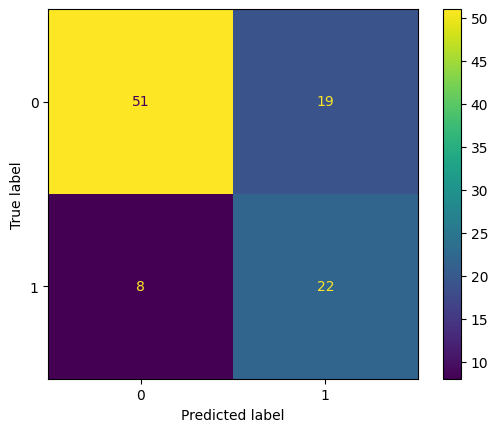

In [147]:
scaler = StandardScaler()
pca = PCA()
classifier = LogisticRegression()

pipeline = Pipeline([
                    # ('scaler', scaler),
                    #  ('pca', pca),
                     ('classifier', classifier)
                     ])


param_grid = {
    # 'scaler__with_mean': [True, False],
    # 'scaler__with_std': [True, False],
    # 'pca__n_components': [1, 2, 3, 5, 10, 15, 20, 25],
    # 'pca__whiten': [False, True],
    # 'pca__svd_solver': ['auto', 'full'],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'classifier__C': np.logspace(-4, 4, 4),
    'classifier__fit_intercept': [True, False],
    'classifier__solver': ['lbfgs', 'liblinear',  'newton-cholesky'],
    'classifier__max_iter': [10, 25, 50, 100, 150, 200, 250, 500, 750, 1000, 1500]
}

search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, refit=True, return_train_score=True)

search.fit(X_train, y_train)

print('fitted')
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# y_pred = pipeline.predict(X_test)
y_pred_proba = search.predict_proba(X_test)
y_pred = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)


print('PREDICTIONS ON TEST:')
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print('Predicted classes:\n\t{}\n'.format(dict(zip(*np.unique(y_pred, return_counts=True)))))
ConfusionMatrixDisplay(cm).plot()
print('Gini: \n\t{}'.format(gini(y_test, y_pred)))

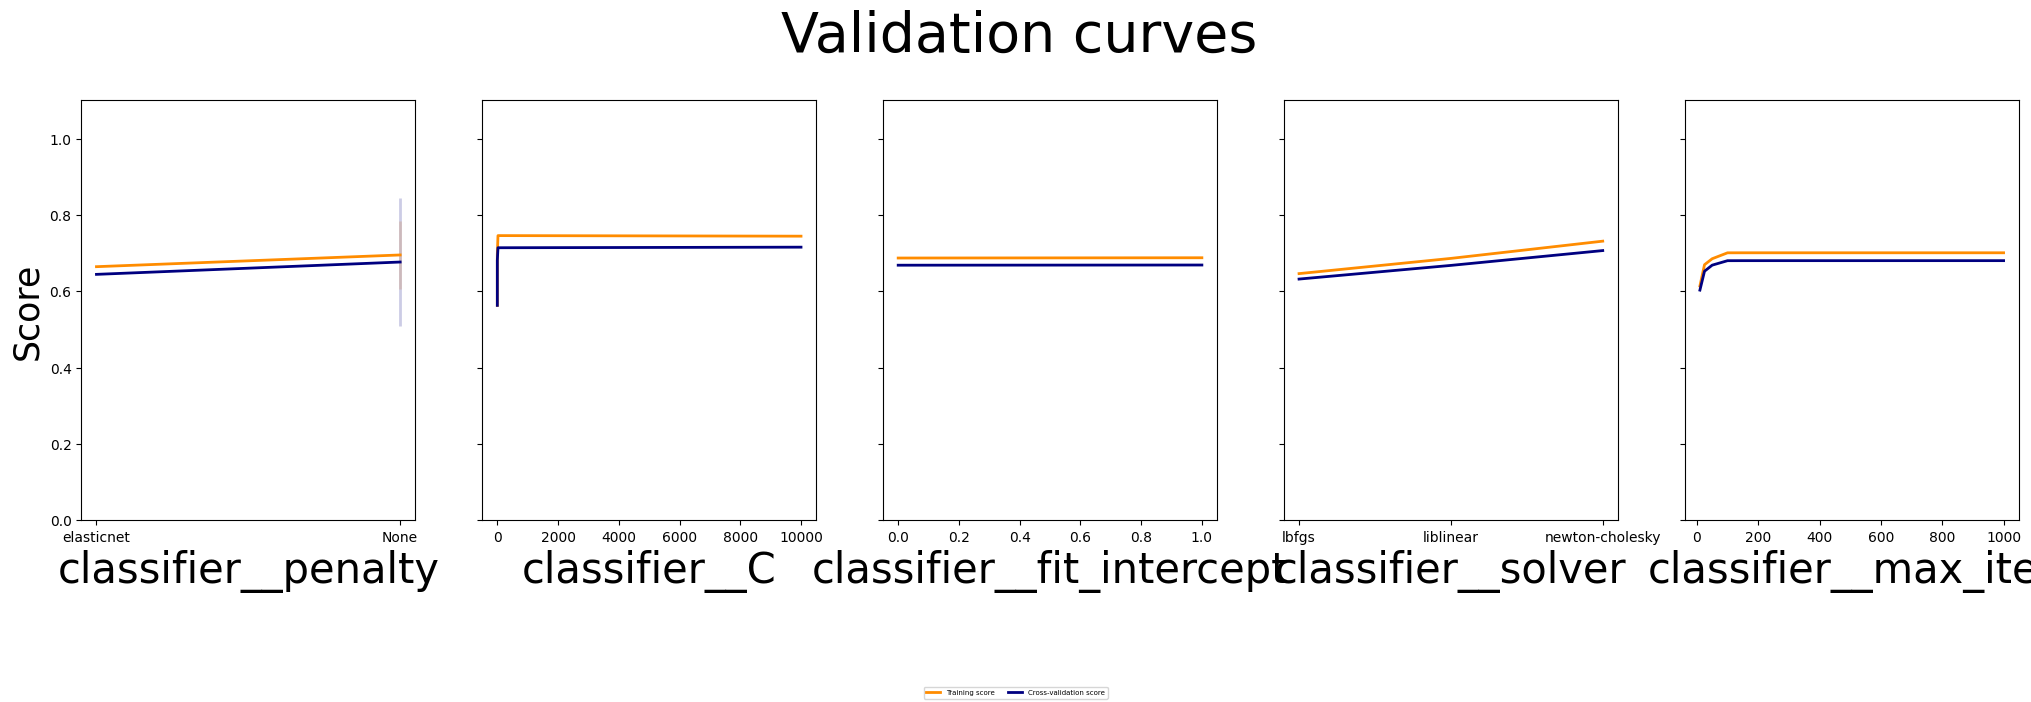

In [127]:
df = pd.DataFrame(search.cv_results_)
results = ['mean_test_score',
           'mean_train_score',
           'std_test_score', 
           'std_train_score']

# https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
def pooled_var(stds):
    n = 5 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))


fig, axes = plt.subplots(1, len(param_grid), 
                         figsize = (5*len(param_grid), 7),
                         sharey='row')
axes[0].set_ylabel("Score", fontsize=25)
lw = 2

for idx, (param_name, param_range) in enumerate(param_grid.items()):
    grouped_df = df.groupby(f'param_{param_name}')[results]\
        .agg({'mean_train_score': 'mean',
              'mean_test_score': 'mean',
              'std_train_score': pooled_var,
              'std_test_score': pooled_var})

    previous_group = df.groupby(f'param_{param_name}')[results]
    axes[idx].set_xlabel(param_name, fontsize=30)
    axes[idx].set_ylim(0.0, 1.1)
    axes[idx].plot(param_range, 
                grouped_df['mean_train_score'],
                label="Training score",
                color="darkorange",
                lw=lw)
    axes[idx].fill_between(param_range,
                grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                grouped_df['mean_train_score'] + grouped_df['std_train_score'],
                alpha=0.2,
                color="darkorange",
                lw=lw)
    axes[idx].plot(param_range,
                grouped_df['mean_test_score'],
                label="Cross-validation score",
                color="navy",
                lw=lw)
    axes[idx].fill_between(param_range,
                    grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                    grouped_df['mean_test_score'] + grouped_df['std_test_score'],
                    alpha=0.2,
                    color="navy",
                    lw=lw)

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=40)
fig.legend(handles, labels, loc=8, ncol=2, fontsize=5)

fig.subplots_adjust(bottom=0.25, top=0.85)  
plt.show()

In [128]:
print(f'Alphas:\t{search.best_estimator_.named_steps.classifier.coef_}\n\nBeta:\t{search.best_estimator_.named_steps.classifier.intercept_}')

Alphas:	[[-1.00446932e-02  3.48923908e-01  5.82803565e-06  3.66551877e-02
  -1.06839610e-01 -5.23559602e-01 -4.88665920e-01 -3.88269658e-01
  -4.61312236e-01 -7.23835557e-01 -3.22186997e-01  6.80142150e-01
   5.95358244e-01 -1.11126061e-01 -3.79033484e-01  1.68039757e+00
   1.27698483e+00  7.36633271e-01 -2.64357115e-01 -3.01531920e-01
  -4.20889191e-02  2.60766834e-01 -3.62635380e-01 -6.21020560e-01
   1.49318161e-01 -3.25785891e-01]]

Beta:	[-1.50733479]


In [130]:
print(f'Accuracy: {search.best_estimator_.score(X_test, y_test)}')

Accuracy: 0.75


## Trynna oversample

In [144]:
from imblearn.pipeline import Pipeline as imb_Pipeline
from imblearn.over_sampling import SMOTE

In [156]:
smote = SMOTE(random_state=42)
smote_logreg = LogisticRegression()

over_pipe = imb_Pipeline(steps=[
    ('smote', smote),
    ('scaler', scaler),
    ('classifier', smote_logreg)
])

over_param_grid = {
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False],
    'classifier__penalty': ['l2', 'None'],
    'classifier__C': np.logspace(-4, 4, 4),
    'classifier__fit_intercept': [True, False],
    'classifier__solver': ['lbfgs', 'liblinear', 'newton-cholesky'],
    'classifier__max_iter': [10, 25, 50, 100, 150, 200, 250, 500, 750, 1000, 1500]
}

over_search = GridSearchCV(over_pipe, over_param_grid, scoring='roc_auc', verbose=1, refit=True, return_train_score=True)
over_search.fit(X_train, y_train)

print('Fitted\n')
print(over_search.best_estimator_)
print()

over_search_y_pred_proba = over_pipe.predict_proba(X_test)
over_search_y_pred = np.where(over_search_y_pred_proba[:,1] > THRESHOLD, 1, 0)


print('PREDICTIONS ON TEST:')
print(classification_report(y_test, over_search_y_pred))

Fitting 5 folds for each of 2112 candidates, totalling 10560 fits


/Users/fedorpakhurov/miniconda3/envs/coursepaper/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fedorpakhurov/miniconda3/envs/coursepaper/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Fitted

Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=21.54434690031882, max_iter=10,
                                    solver='liblinear'))])



/Users/fedorpakhurov/miniconda3/envs/coursepaper/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5280 fits failed out of a total of 10560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5280 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fedorpakhurov/miniconda3/envs/coursepaper/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fedorpakhurov/miniconda3/envs/coursepaper/lib/python3.10/site-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/fedorpakhurov/miniconda3/envs/

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Exporting final model  
From initial pipeline

In [161]:
pickle.dump(search.best_estimator_, open('models/model.pkl', 'wb'))

In [162]:
final_model = pickle.load(open('models/model.pkl', 'rb'))
final_model

Pipeline(steps=[('classifier',
                 LogisticRegression(C=10000.0, max_iter=50,
                                    solver='liblinear'))])

# Prerequisites for the Flask integration

In [188]:
print('Feature names and types:\n' + X_train.dtypes.to_string())

Feature names and types:
age                              int64
sex                              int64
credit_amount                  float64
duration                         int64
job_unskilled_non_resident       int64
job_unskilled_and_resident       int64
job_skilled                      int64
job_highly_skilled               int64
housing_free                     uint8
housing_own                      uint8
housing_rent                     uint8
saving_accounts_little           uint8
saving_accounts_moderate         uint8
saving_accounts_quite_rich       uint8
saving_accounts_rich             uint8
checking_account_little          uint8
checking_account_moderate        uint8
checking_account_rich            uint8
purpose_business                 uint8
purpose_car                      uint8
purpose_domestic_appliances      uint8
purpose_education                uint8
purpose_furniture_equipment      uint8
purpose_radio_tv                 uint8
purpose_repairs                  uint8


In [189]:
X.describe()

,age,sex,credit_amount,duration,job_unskilled_non_resident,job_unskilled_and_resident,job_skilled,job_highly_skilled,housing_free,housing_own,...,checking_account_moderate,checking_account_rich,purpose_business,purpose_car,purpose_domestic_appliances,purpose_education,purpose_furniture_equipment,purpose_radio_tv,purpose_repairs,purpose_vacation_others
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,35.546000,0.310000,10208.974679,20.903000,0.022000,0.2000,0.630000,0.148000,0.108000,0.713000,...,0.269000,0.063000,0.097000,0.337000,0.01200,0.059000,0.181000,0.280000,0.022000,0.01200
std,11.375469,0.462725,8809.225470,12.058814,0.146757,0.4002,0.483046,0.355278,0.310536,0.452588,...,0.443662,0.243085,0.296106,0.472921,0.10894,0.235743,0.385211,0.449224,0.146757,0.10894
min,19.000000,0.000000,780.202500,4.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,27.000000,0.000000,4261.466055,12.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,33.000000,0.000000,7238.718795,18.000000,0.000000,0.0000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,42.000000,1.000000,12396.637522,24.000000,0.000000,0.0000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000
max,75.000000,1.000000,57497.803440,72.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000
